# Python Project
## Joseph Slattery

### Q1
First finding a second order ODE for position q: \
$$F_R = F_d + u$$
$$F_d = γ(v_b - v) = γ(\beta R_\theta q - \dot q)$$
$$F_R = m\ddot q = γ(\beta R_\theta q - \dot q) + u$$

Now Reformulating to find a first order ODE of state: x = [q, p]ᵀ
$$p=m\dot q$$
$$\dot q = \frac{1}{m}p$$
$$\dot p = m\ddot q = -γ\dot q + γ\beta R_\theta q + u$$
$$\dot p = -\frac{γ}{m}p + γ\beta R_\theta q + u$$

Now putting the two first order ODEs in matrix form:
$$\dot x = \begin{bmatrix}
\dot q\\
\dot p
\end{bmatrix} = \begin{bmatrix}
0 & \frac{1}{m}\\
\gamma \beta R_θ & -\frac{γ}{m}
\end{bmatrix} \begin{bmatrix}
q\\
p
\end{bmatrix} + \begin{bmatrix}
0\\
1 \end{bmatrix} u$$







### Q2
Implicit Euler Method to find a numerical solution to the first order ODE in form:
$$\dot x = Ax + bu$$
Implicit Euler Scheme:
$$X(t_i) = (I- \Delta t_{i}A)^{-1} (X(t_{i-1})- \Delta t_ib)$$

Distance from origin after 15s: [2.08129315]m


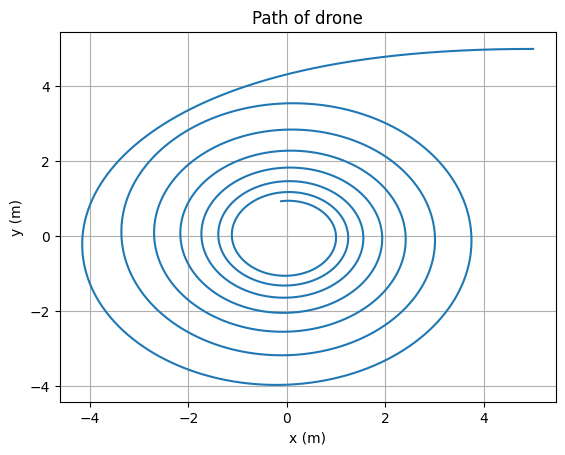

In [1]:
### Q2
import numpy as np
import matplotlib.pyplot as plt



# Input parameters
m = 1.5
gamma = 2.5
beta = 2
theta = 3*np.pi/4

# Construct Matracies
#Rotation
R = np.array([[np.cos(theta), -np.sin(theta)],
              [np.sin(theta), np.cos(theta)]])
# A
A = np.array([[0, 0, 1/m, 0],
              [0, 0, 0, 1/m],
              [R[0, 0]*beta*gamma, R[0, 1]*beta*gamma, -gamma/m, 0],
              [R[1, 0]*beta*gamma, R[1, 1]*beta*gamma, 0, -gamma/m]])
# b1
b1 = np.array([[0, 0],
              [0, 0],
              [1, 0],
              [0, 1]])
# u
u = np.array([[0],
              [0]])
# b
b = np.dot(b1,u)

# T
T = np.linspace(0, 30, 30001)
# x0
x0 = np.array([[5],
               [5],
               [0],
               [0]])



def benign_euler_method(A, b, x0, T):
    # Create emply list the same length as the time
    X = [None for i in T]
    # Set the initial states x
    X[0] = x0
    # Find the time delta (assuming linear spacing)
    dt = T[1]-T[0]
    # Find the number of dimension of X
    n = len(x0)
    # Loop through the time vector
    for i in range(1, len(T)):
        # Implement the implicit Euler method for each time
        X[i] = np.linalg.solve(np.eye(n) - dt*A, X[i-1] + dt*b)
    return T, X
# Use the function to find the states X
T, X = benign_euler_method(A, b, x0, T)

# Create a list for each state
q0 = np.array([x[0] for x in X])
q1 = np.array([x[1] for x in X])
p0 = np.array([x[2] for x in X])
p1 = np.array([x[3] for x in X])

# Plot the path of the drone
fig, ax = plt.subplots()
ax.set_title("Path of drone")
ax.set_ylabel("y (m)")
ax.set_xlabel("x (m)")
ax.plot(q0, q1)
ax.grid()

# Print the distance after 15s
print(f"Distance from origin after 15s: {np.sqrt(q0[15000]**2 + q1[15000]**2)}m")


### Q3
Applying the Kalman filter to estimate the mean value of the signal given noisy observations. This is done in two steps: predict, where the next mean and covariances are calculated and update where the Kalman filter is applied.\
Noisy observations:
$$y_i = H x_i + \varepsilon_i$$
Predict:
$$\hat m_{i+1}=Fm_i+f_i$$
$$\hat C_{i+1} = FC_iF^T$$

Update:
$$m_{i+1} = \hat m_{i+1} + \hat C_{i+1}H^T(H\hat C_{i+1}H^T+ R)(y_{i+1}-H\hat m_{i+1})$$
$$C_{i+1} = \hat C_{i+1} + \hat C_{i+1}H^T(H\hat C_{i+1}H^T+ R)H\hat C_{i+1}$$


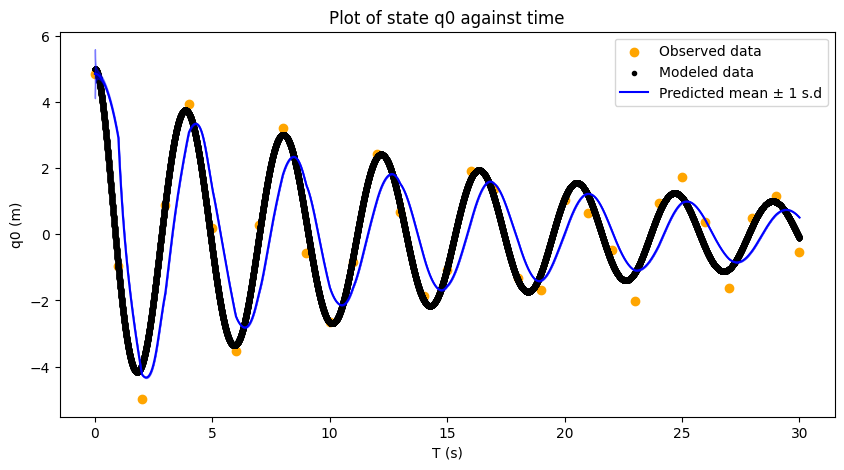

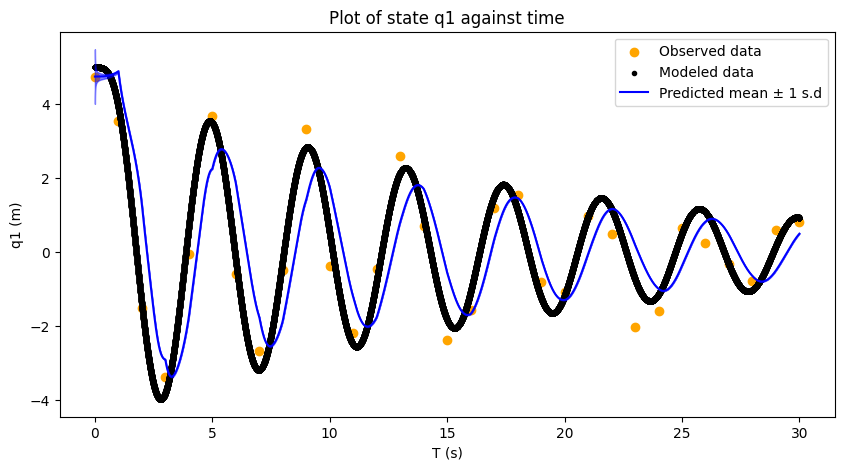

In [2]:
### Q3
import numpy as np
import matplotlib.pyplot as plt

# Construct matracies
F = np.linalg.inv(np.eye(4) - 0.001*A)
H = np.array([[1, 0, 0, 0],
              [0, 1, 0, 0]])
R = 0.5*np.eye(2)

# Adding random noise to x at each interger time
# Create empty list same length as T
y = [None for t in T]
yp = []
Ti = [i for i in range(31)]

# Looping through the time vector
for i in range(len(T)):
    if T[i] % 1 == 0:
        # Multiply by observation matrix and add random noise
        yy = np.dot(H, X[i]) + np.array([[np.random.normal(0, 0.5)], [np.random.normal(0, 0.5)]])
        yp.append(yy)
    y[i] = yy


# Predict function
def predict(F, m, C):
    mHat = np.dot(F, m)
    CHat = np.dot(F, np.dot(C, F))
    return mHat, CHat

# Update function
def update(mHat, CHat, H, y, R):
    # Kalman Gain
    I = np.dot(np.dot(H, CHat), H.T) + R
    KG = np.dot(np.dot(CHat, H.T), np.linalg.inv(I))
    # Residual
    R = y - np.dot(H, mHat)
    # Final Value
    m = mHat + np.dot(KG, R)
    C = CHat - np.dot(KG, np.dot(H, CHat))
    return m, C

# Create empty lists for m and C
m = [None for t in T]
C = [None for t in T]

# Instalise the initial values of m and C
m[0] = np.zeros((4, 1))
C[0] = 10**6*np.eye(4)

# Use the functions to find m and C for each value of T
m[0], C[0] = update(m[0], C[0], H, y[0], R)
for i in range(1, len(T)):
    m[i], C[i] = predict(F, m[i-1], C[i-1])
    m[i], C[i] = update(m[i], C[i], H, y[i], R)

# Extract arrays of q0 and q1 from lists created
yq0 = np.array([y[0] for y in yp])
yq1 = np.array([y[1] for y in yp])
mq0 = np.array([mm[0] for mm in m])
mq1 = np.array([mm[1] for mm in m])
mp0 = np.array([mm[2] for mm in m])
mp1 = np.array([mm[3] for mm in m])



# Plot q0
c0 = np.array([c[0][0] for c in C])
sdq0 = np.array([np.sqrt(abs(c0))])
diflo = mq0 - sdq0.T
difhi = mq0 + sdq0.T

fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(Ti, yq0, color="orange", label="Observed data");
ax.scatter(T, q0, marker='.', color="black", label="Modeled data");
ax.plot(T, mq0, color="blue", label="Predicted mean ± 1 s.d");
ax.fill_between(T, diflo.flatten(), difhi.flatten(), alpha=0.5, color="blue");
ax.set_title("Plot of state q0 against time");
ax.set_ylabel("q0 (m)")
ax.set_xlabel("T (s)")
ax.legend()

# Plot q1
c1 = np.array([c[1][1] for c in C])
sdq1 = np.array([np.sqrt(abs(c1))])
diflo = mq1 - sdq1.T
difhi = mq1 + sdq1.T

fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(Ti, yq1, color="orange", label="Observed data");
ax.scatter(T, q1, marker='.', color="black", label="Modeled data");
ax.plot(T, mq1, color="blue", label="Predicted mean ± 1 s.d");
ax.fill_between(T, diflo.flatten(), difhi.flatten(), alpha=0.5, color="blue");
ax.set_title("Plot of state q1 against time");
ax.set_ylabel("q1 (m)")
ax.set_xlabel("T (s)")
ax.legend()



The predicted mean generally follows the model, while taking account of the observations. This causes the predicted position in the x and y direction to osilate with the same frequency as the model, however it has a slightly higher amplitude, and is out of phase. This error is due to the observations not being made frequently enough with $ΔT=1s$, compared to the predictions being made with $ΔT=0.001s$.\
The standard deviation in both directions starts off relatively large with a value of 0.5 but decreases to aproximately zero after < 1s.


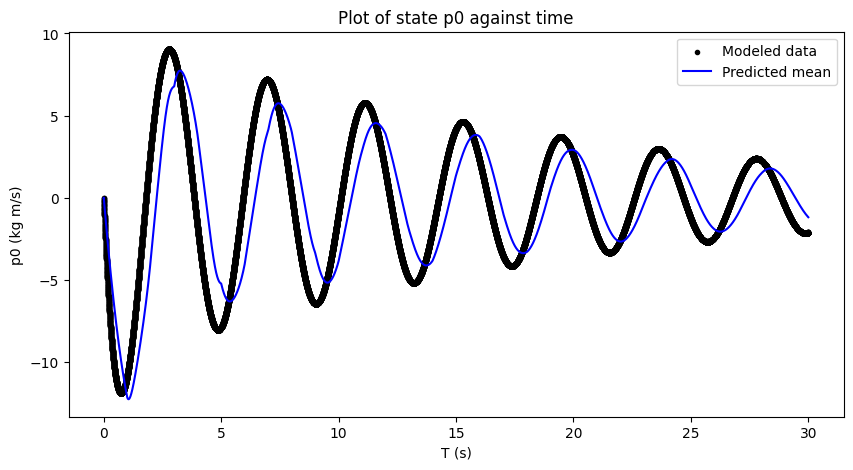

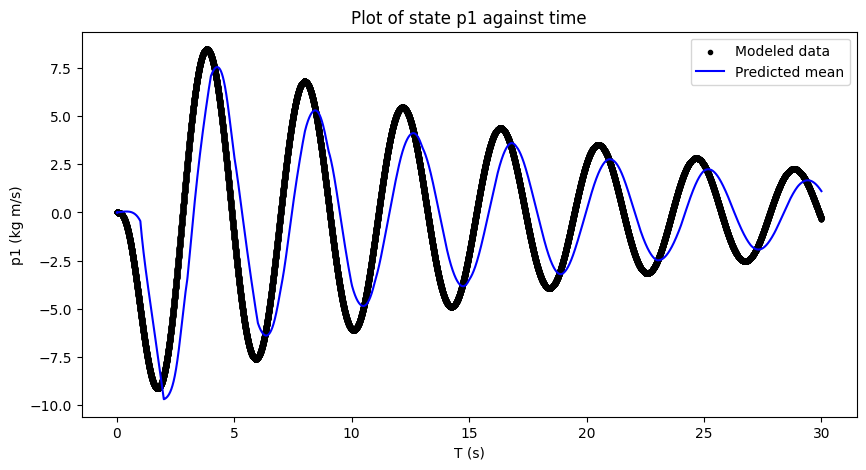

In [3]:
mp0 = np.array([mm[2] for mm in m])
mp1 = np.array([mm[3] for mm in m])

# Plot p0
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(T, p0, marker='.', color="black", label="Modeled data");
ax.plot(T, mp0, color="blue", label="Predicted mean");
ax.set_title("Plot of state p0 against time");
ax.set_ylabel("p0 (kg m/s)")
ax.set_xlabel("T (s)")
ax.legend()

# Plot p1
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(T, p1, marker='.', color="black", label="Modeled data");
ax.plot(T, mp1, color="blue", label="Predicted mean");
ax.set_title("Plot of state p1 against time");
ax.set_ylabel("p1 (kg m/s)")
ax.set_xlabel("T (s)")
ax.legend()




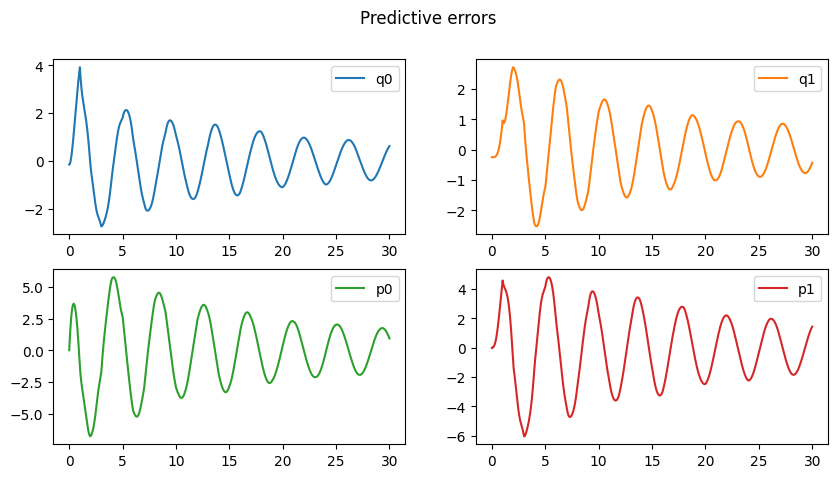

In [4]:
# Calculate predictive error
PSE = [np.subtract(m[i], X[i]) for i in range(len(T))]

# Plot predictive errors
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 5))
fig.suptitle('Predictive errors')
ax1.plot(T, [x[0] for x in PSE], label='q0')
ax1.legend()
ax2.plot(T, [x[1] for x in PSE], 'tab:orange', label='q1')
ax2.legend()
ax3.plot(T, [x[2] for x in PSE], 'tab:green', label='p0')
ax3.legend()
ax4.plot(T, [x[3] for x in PSE], 'tab:red', label='p1')
ax4.legend()


The predictive errors of the states osilate similar to the states themselves, with the same fequency but out of phase. There is a general trend of decreasing apliplitude of error, which is due to the states amplitude decreasing so the errors amplitude also decreases.

### Q4
The force of the wirlpool with the drone to rest at $(-1, 1)m$ would be:
$$f = γβR_{3π/4}q$$
$$= 2 ⋅ 2.5 \begin{bmatrix}
-0.707&-0.707\\
0.707&-0.707
\end{bmatrix}\begin{bmatrix}
-1\\
1
\end{bmatrix} = \begin{bmatrix}
0\\
-7.07
\end{bmatrix}N$$

Is not possible to bring the drone to rest here beacuse $||u||≤5N$. It was therefore calculated that the closest point to $(-1, 1)m$ where the drone can be brought to rest is $(-0.707, 0.707)m$. The target was set to this value to make the controler more accurate. There is a 10% error tollerance introduced as well, because the contoller is using estimates of the mean, not the true values. This would give a overall steady state error of $0.414m$ and with the 10% tolerance the drone should be at rest $\le 0.455m$ from $(-1, 1)m$.


Steady state position = ([-0.70392952], [0.68389197])m
Distance from target point = [0.4331074]m


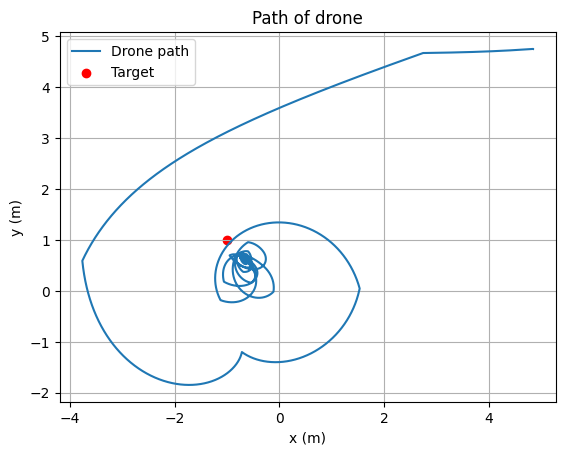

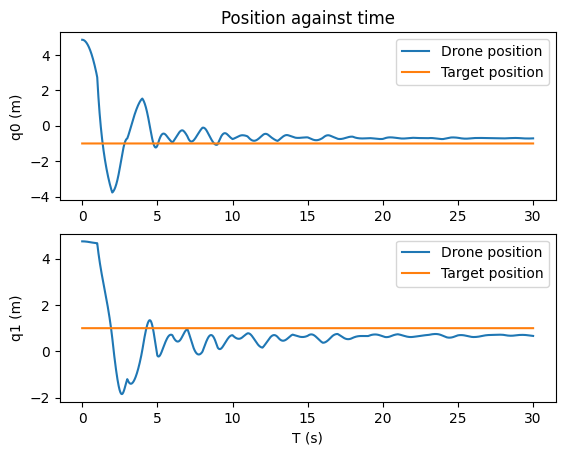

In [5]:
### Q4

# Instalising constants
F = np.linalg.inv(np.eye(4) - 0.001*A)
H = np.array([[1, 0, 0, 0],
              [0, 1, 0, 0]])
R = 0.5*np.eye(2)
mass = 1.5
b = np.array([[0, 0],
              [0, 0],
              [1, 0],
              [0, 1]])


# Predict and update functions imported from Q3
def predict(F, f, m, C):
    mHat = np.dot(F, m) + 0.001*f
    CHat = np.dot(F, np.dot(C, F))
    return mHat, CHat


def update(mHat, CHat, H, y, R):
    # Kalman Gain
    I = np.dot(np.dot(H, CHat), H.T) + R
    KG = np.dot(np.dot(CHat, H.T), np.linalg.inv(I))
    # Residual
    R = y - np.dot(H, mHat)
    # Final Value
    m = mHat + np.dot(KG, R)
    C = CHat - np.dot(KG, np.dot(H, CHat))
    return m, C


# Chosen staring value for u
u = np.array([[-2],
              [-3]])

m = [None for t in T]
C = [None for t in T]

f = np.dot(b,u)
target_q = (np.sqrt(2)/2)*np.array([[-1],
                   [1]])
target_p = np.array([[0],
                   [0]])

dt = 0.001

kp = 3
kd = 1

m[0] = np.zeros((4, 1))
C[0] = 10**6*np.eye(4)

m[0], C[0] = update(m[0], C[0], H, y[0], R)

for i in range(1, len(T)):
    m[i], C[i] = predict(F, f, m[i-1], C[i-1])
    m[i], C[i] = update(m[i], C[i], H, y[i], R)
    # Find appropriate value for u given m
    u = kp*(target_q - m[i][0:2]) + kd*(target_p - (1/mass)*m[i][2:4])
    # Normalise u
    u = (5/np.sqrt(u[0]**2 + u[1]**2))*u
    f = np.dot(b,u)

m0 = np.array([x[0] for x in m])
m1 = np.array([x[1] for x in m])
m2 = np.array([x[2] for x in m])
m3 = np.array([x[3] for x in m])

fig, ax = plt.subplots()
ax.plot(m0, m1, label='Drone path')
ax.scatter(-1, 1, color='r', label='Target')
ax.set_title('Path of drone')
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.legend()
ax.grid()

fig, ax = plt.subplots(2, 1)
ax[0].plot(T, m0, label='Drone position')
ax[0].plot(T, -1*np.ones(len(T)), label='Target position')
ax[0].set_title('Position against time')
ax[0].set_ylabel('q0 (m)')
ax[0].legend()
ax[1].plot(T, m1, label='Drone position')
ax[1].plot(T, 1*np.ones(len(T)), label='Target position')
ax[1].set_ylabel('q1 (m)')
ax[1].set_xlabel('T (s)')
ax[1].legend()

ss0 = sum(m0[25000:30000])/len(m0[25000:30000])
ss1 = sum(m1[25000:30000])/len(m1[25000:30000])

x = np.sqrt((-1-ss0)**2+(1-ss1)**2)
print(f'Steady state position = ({ss0}, {ss1})m')
print(f'Distance from target point = {np.sqrt((-1-ss0)**2+(1-ss1)**2)}m')